# MSDS 462 Assignment 1 Fashion - MNIST

Training a CNN for Fashion MNIST dataset using Keras and Tensorflow. Fashion MNIST dataset contains Grayscale images from 10 classes. The train dataset has 60000 images (6000 per class) and the test dataset has 10000 images. This CNN has two Convolutional layers, works on a 3 x 3 kernel, activation function is 'relu'. The final output layer consists of 10 output nodes with 'softmax' function. The 'Adam' optimizer was used along with 'sparse_categorical_crossentropy' loss function.

The model took nearly 8 hours to train and reached a predictive accuracy of 94% and a validation accuracy of 92%.

In [46]:
###############################################################################
# Pyhton packages
###############################################################################
from __future__ import absolute_import, division, print_function, unicode_literals

# To remove all future warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from keras.datasets import fashion_mnist
#from keras import models
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPooling2D, Input
from keras.layers import Flatten, Dense, Dropout
from keras.models import Model
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras import backend as K

from sklearn.metrics import roc_curve, auc
import skimage
from skimage.transform import resize
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns

import glob
import os, sys
import math
import pandas as pd
import time
from contextlib import redirect_stdout

import time

import numpy as np

### Loading and processing data

In [74]:
###############################################################################
# Download and normalization pre-processing (0-1) of the Fashion-MNIST dataset
###############################################################################
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

height=28
width=28

#Checking number of images per class
objclass, counts = np.unique(train_labels, return_counts = True)

print("Updated count of images per class")
dict(zip(objclass, counts))

# Shape of the image datasets
print(train_images.shape) 
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

Updated count of images per class
(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


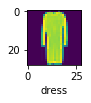

In [75]:
# Class Names for the dataset
class_names = ['top', 'trouser', 'pullover', 'dress', 'coat',
               'sandal', 'shirt', 'sneaker', 'bag', 'boot']

plt.figure(figsize=(1,1))
plt.imshow(train_images[25])
plt.xlabel(class_names[train_labels[25]])
plt.show()

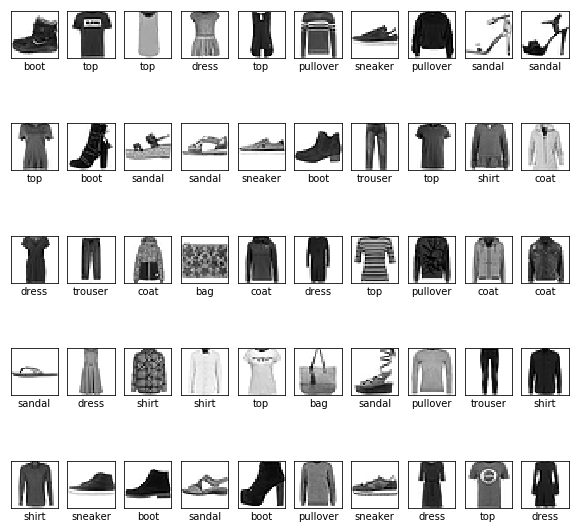

Updated count of images per class
{0: 6000, 1: 6000, 2: 6000, 3: 6000, 4: 6000, 5: 6000, 6: 6000, 7: 6000, 8: 6000, 9: 6000}
Updated count of images per class
{0: 1000, 1: 1000, 2: 1000, 3: 1000, 4: 1000, 5: 1000, 6: 1000, 7: 1000, 8: 1000, 9: 1000}


In [49]:
start_time = time.clock()

class_name_dict = {
    0: 'top',
    1: 'trouser',
    2: 'pullover',
    3: 'dress',
    4: 'coat',
    5: 'sandal',
    6: 'shirt',
    7: 'sneaker',
    8: 'bag',
    9: 'boot',
}

def draw_img(i):
    im = train_images[i]
    c = train_labels[i]
    plt.imshow(im)
    plt.title("Class %d (%s)" % (c, class_name_dict[c]))
    plt.axis('on')
    im


def draw_sample(X, y, n, rows=4, cols=4, imfile=None, fontsize=12):
    for i in range(0, rows*cols):
        plt.subplot(rows, cols, i+1)
        im = X[n+i].reshape(28,28,1)
        plt.imshow(im, cmap='gnuplot2')
        plt.title("{}".format(class_name_dict[y[n+i][0]]), fontsize=fontsize)
        plt.axis('off')
        plt.subplots_adjust(wspace=0.6, hspace=0.01)
        #plt.subplots_adjust(hspace=0.45, wspace=0.45)
        #plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    if imfile:
        plt.savefig(imfile)

def central_scale_images(X_imgs, scale):
    # scaled_imgs = central_scale_images(X_imgs, [0.90, 0.75, 0.60])
    # Various settings needed for Tensorflow operation
    boxes = np.zeros((1, 4), dtype = np.float32)
    for index, scale in enumerate([scale]):
        x1 = y1 = 0.5 - 0.5 * scale # To scale centrally
        x2 = y2 = 0.5 + 0.5 * scale
        boxes[index] = np.array([y1, x1, y2, x2], dtype = np.float32)
    box_ind = np.zeros(1, dtype = np.int32)
    crop_size = np.array([height, width], dtype = np.int32)
    
    X_scale_data = []
    tf.reset_default_graph()
    X = tf.placeholder(tf.float32, shape = (1, height, width, 3))
    # Define Tensorflow operation for all scales but only one base image at a time
    tf_img = tf.image.crop_and_resize(X, boxes, box_ind, crop_size)
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        for img_data in X_imgs:
            batch_img = np.expand_dims(img_data, axis = 0)
            scaled_imgs = sess.run(tf_img, feed_dict = {X: batch_img})
            X_scale_data.extend(scaled_imgs)
    
    X_scale_data = np.array(X_scale_data, dtype = np.float32)
    return X_scale_data


###############################################################################
# Finish pre-processing (0-1) of the Fashion-MNIST dataset
###############################################################################

# Normalize pixel values to be between 0 and 1
train_images, test_images = train_images / 255.0, test_images / 255.0

###############################################################################
# Visualizing the first 50 images in the dataset 
###############################################################################

plt.figure(figsize=(10,10))
for i in range(50):
    plt.subplot(5,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    # The CIFAR labels happen to be arrays, 
    # which is why you need the extra index
    plt.xlabel(class_names[train_labels[i]])
plt.show()

#Checking number of images per class in the new Train Set
objclass, counts = np.unique(train_labels, return_counts = True)

print("Updated count of images per class")
print(dict(zip(objclass, counts)))

#Checking number of images per class in the new Test Set
objclass, counts = np.unique(test_labels, return_counts = True)

print("Updated count of images per class")
print(dict(zip(objclass, counts)))

### Convolutional Neural Network Code
To be run only if a saved model is not available otherwise load from existing model

In [54]:
# Code to load existing model to avoid retraining multiple times
# Commenting the code for now
model = keras.models.load_model('cnn_fashionmnist_model_20191201.h5')

In [38]:
###############################################################################
# Convolutional Neural Network Architecture
# Build a Convolutional Neural Network in four blocks:
# 1.Convolution layers ==> 2.Pooling layer ==> 3.Flattening layer ==> 4.Dense/Output layer
# Dropout - addresses overfitting
# Kernel_regularizer - penalizes on layer parameters during optimization - L2 regularisation of the weights
# BatchNormalization - addresses the internal covariate shift, even eliminating the need for dropout
# and achieves same accuracy with fewer training steps speeding up the training process

# Configure CNN tensors shape (image_height, image_width, color_channels)
# Inputs orignal format of Fashion-MNIST images of shape (28, 28, 1)
# Apply Conv2D and MaxPooling2D layer
# Color channel is Grayscale
# Display the model architecture
# Output of Conv2D and MaxPooling2D layers in 3D tensor shape (height, width, channels)
# Number of output channels for Conv2D layers = 32, 64
# Print the model architecture 
###############################################################################
weight_decay = 1e-4
# Initializing the model
model = models.Sequential()

# Step 1. Convolution layer
# padding the input such that the output has the same length as the original input
# Step 2. Pooling layer: add MaxPooling to downsample and Dropout to prevent overfitting

# 1st convolutional layer
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=regularizers.l2(weight_decay),
                        input_shape=(28, 28, 1)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(32, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.2))

# 2nd convolutional layer
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.Conv2D(64, (3, 3), padding='same', activation='relu',
                        kernel_regularizer=regularizers.l2(weight_decay)))
model.add(layers.BatchNormalization())
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Dropout(0.3))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
__________

In [39]:
###############################################################################
# Step 3. Flattening layer from 3D output to 1D
# Step 4. Dense/Output layer: one or more Dense layers
# Add final Dense layer of 10 outputs and softmax activation
# Print the model architecture 
###############################################################################
# Step 3. Flattening layer: from 3D output to 1D
model.add(layers.Flatten())
# Step 4. Dense/Output layer
# softmax as our last activation function
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
# Print the model architecture 
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 28, 28, 32)        320       
_________________________________________________________________
batch_normalization_v1_4 (Ba (None, 28, 28, 32)        128       
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 28, 28, 32)        9248      
_________________________________________________________________
batch_normalization_v1_5 (Ba (None, 28, 28, 32)        128       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 14, 14, 64)        18496     
__________

In [40]:
train_images = np.reshape(train_images, (60000,28,28,1))
train_labels = np.reshape(train_labels, (60000,1))
test_images = np.reshape(test_images, (10000,28,28,1))
test_labels = np.reshape(test_labels, (10000,1))

print(train_images.shape) 
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(60000, 28, 28, 1)
(60000, 1)
(10000, 28, 28, 1)
(10000, 1)


### Training the Model using 60000 Train images and 10000 Validation samples

In [42]:
###############################################################################
# Train the model
# Train on 60000 samples, validate on 10000 samples
###############################################################################
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(train_images, train_labels, epochs=10, 
                    validation_data=(test_images, test_labels))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 671s 11ms/sample - loss: 0.4151 - acc: 0.8551 - val_loss: 0.2944 - val_acc: 0.8986
Epoch 2/10
60000/60000 [==============================] - 982s 16ms/sample - loss: 0.2834 - acc: 0.9028 - val_loss: 0.2690 - val_acc: 0.9082
Epoch 3/10
60000/60000 [==============================] - 1072s 18ms/sample - loss: 0.2565 - acc: 0.9149 - val_loss: 0.2693 - val_acc: 0.9071
Epoch 4/10
60000/60000 [==============================] - 1072s 18ms/sample - loss: 0.2380 - acc: 0.9224 - val_loss: 0.2583 - val_acc: 0.9170
Epoch 5/10
60000/60000 [==============================] - 1104s 18ms/sample - loss: 0.2282 - acc: 0.9277 - val_loss: 0.2586 - val_acc: 0.9194
Epoch 6/10
60000/60000 [==============================] - 1076s 18ms/sample - loss: 0.2180 - acc: 0.9321 - val_loss: 0.2735 - val_acc: 0.9108
Epoch 7/10
60000/60000 [==============================] - 5356s 89ms/sample - loss: 0.2111 - acc: 0.

In [43]:
# Recording the time took for training
print("Time Elapsed = ", time.clock() - start_time)

# Save the model
model.save('cnn_fashionmnist_model_20191201.h5')

Time Elapsed =  28192.5464458


### Evaluating the model

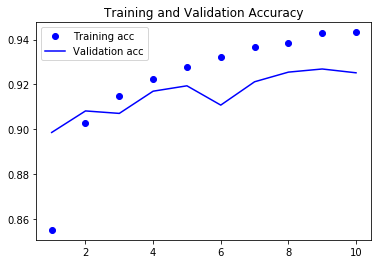

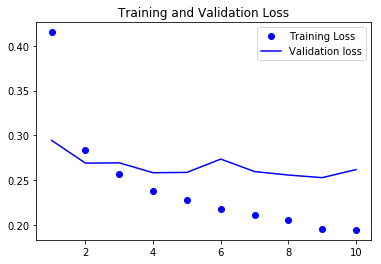

 - 104s - loss: 0.2618 - acc: 0.9252


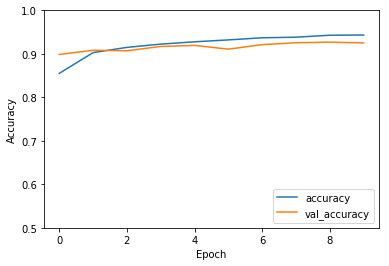

In [44]:
###############################################################################
# Evaluate the model
# Visualize the model accuracy
###############################################################################
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

###############################################################################
# Evaluate the model
# Visualize the model accuracy
###############################################################################
plt.plot(history.history['acc'], label='accuracy')
plt.plot(history.history['val_acc'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(test_images,  test_labels, verbose=2)

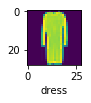

Predicted class is: [3] - dress


In [83]:
###############################################################################
# Predicting new images
###############################################################################

plt.figure(figsize=(1,1))
plt.imshow(train_images[25])
plt.xlabel(class_names[train_labels[25]])
plt.show()

###############################################################################
# Predicting images
###############################################################################
x = image.img_to_array(train_images[25])
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model.predict_classes(images, batch_size=10)
print("Predicted class is:",classes,"-",class_name_dict[classes[0]])